In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.mlab import PCA as mlabPCA
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
import warnings
%matplotlib inline


warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

lifex = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

lifex.head()



,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


### Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.



#### Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? 

- For the missing values, discuss which technique would be the most suitable one in filling out these values. 

- Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them. 

In [50]:
print(len(lifex))
lifex.isnull().sum()

2938


Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

In [51]:
lifex = lifex.sort_values(by=['Country','Year'])
lifex.head()


,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
15,Afghanistan,2000,Developing,54.8,321.0,88,0.01,10.424960,62.0,6532,...,24.0,8.20,24.0,0.1,114.560000,293756.0,2.3,2.5,0.338,5.5
14,Afghanistan,2001,Developing,55.3,316.0,88,0.01,10.574728,63.0,8762,...,35.0,7.80,33.0,0.1,117.496980,2966463.0,2.1,2.4,0.340,5.9
13,Afghanistan,2002,Developing,56.2,3.0,88,0.01,16.887351,64.0,2486,...,36.0,7.76,36.0,0.1,187.845950,21979923.0,19.9,2.2,0.341,6.2
12,Afghanistan,2003,Developing,56.7,295.0,87,0.01,11.089053,65.0,798,...,41.0,8.82,41.0,0.1,198.728544,2364851.0,19.7,19.9,0.373,6.5
11,Afghanistan,2004,Developing,57.0,293.0,87,0.02,15.296066,67.0,466,...,5.0,8.79,5.0,0.1,219.141353,24118979.0,19.5,19.7,0.381,6.8


To deal with null values for each country, we can backfill values from the year before it. This dataframe has been sorted by year for each country, showing 16 years worth of data. 

In [52]:
np.unique(lifex['Year'])

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015], dtype=int64)

In [53]:
# For each country, fill row of first year using forward fill
index_list = [lifex[lifex['Country']==country].index[0] for country in np.unique(lifex['Country'])] #if lifex.loc[index].isnull().sum() != 0]
print (index_list)

for index in index_list:
    if lifex.loc[index].isnull().sum() != 0:
        lifex.loc[index].fillna(method='ffill',inplace=True)
print(lifex.isnull().sum())
# Now fill the rest of the dataset using backward fill
lifex.fillna(method='backfill',inplace=True)

[15, 31, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256, 272, 288, 304, 320, 336, 352, 368, 384, 400, 416, 432, 463, 479, 495, 511, 527, 543, 559, 575, 591, 607, 623, 624, 640, 656, 672, 688, 704, 447, 720, 736, 752, 768, 769, 785, 801, 817, 834, 850, 866, 882, 898, 914, 930, 946, 962, 978, 994, 1010, 1026, 1042, 1058, 1074, 1090, 1106, 1122, 1138, 1154, 1170, 1186, 1202, 1218, 1234, 1250, 1266, 1282, 1298, 1314, 1330, 1346, 1362, 1378, 1394, 1410, 1426, 1442, 1458, 1474, 1490, 1506, 1522, 1538, 1554, 1570, 1586, 1602, 1618, 1634, 1650, 1651, 1667, 1683, 1699, 1715, 1716, 1732, 1748, 1764, 1780, 1796, 1812, 1813, 1829, 1845, 1861, 1877, 1893, 1909, 1910, 1926, 1942, 1958, 1959, 1975, 1991, 2007, 2023, 2039, 2055, 2071, 2087, 2103, 2119, 2135, 2151, 2167, 2168, 2184, 2200, 2216, 2217, 2233, 2249, 2265, 2281, 2297, 2313, 2329, 2344, 2360, 2376, 2392, 2408, 2424, 2440, 2456, 2472, 2488, 2504, 2520, 2536, 2552, 2568, 2584, 2600, 2616, 2632, 2648, 2664, 2680, 2696, 2712, 2

In [54]:
# strip column titles from whitespace
titles = {k:k.replace(k,k.strip()) for k in lifex.columns}
lifex.rename(columns=titles,inplace=True)


# correlate life expectancy to all variables:
correlation = lifex.corr()
correlation = correlation.sort_values(by=['Life expectancy'], ascending=False)

correlation

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
Life expectancy,0.168374,1.000000,-0.696601,-0.195983,0.367903,0.381277,0.262452,-0.157127,0.545069,-0.221901,0.461525,0.190819,0.476122,-0.555217,0.433047,-0.006870,-0.459941,-0.454309,0.670519,0.681763
Schooling,0.198794,0.681763,-0.411362,-0.174236,0.452774,0.364477,0.195513,-0.093776,0.462554,-0.188823,0.393024,0.216921,0.392231,-0.212311,0.419800,-0.027888,-0.412849,-0.403428,0.803874,1.000000
Income composition of resources,0.231302,0.670519,-0.422667,-0.131608,0.392805,0.360249,0.201286,-0.092683,0.444939,-0.148948,0.368601,0.150135,0.378632,-0.243360,0.431424,0.008004,-0.385990,-0.376020,1.000000,0.803874
BMI,0.107184,0.545069,-0.369614,-0.225616,0.315606,0.225187,0.152954,-0.175970,1.000000,-0.235664,0.268615,0.213923,0.266714,-0.241191,0.276476,-0.046660,-0.534730,-0.541598,0.444939,0.462554
Diphtheria,0.142166,0.476122,-0.276751,-0.171280,0.208535,0.145014,0.535692,-0.138022,0.266714,-0.191611,0.680980,0.129848,1.000000,-0.161892,0.190070,-0.011643,-0.216516,-0.209896,0.378632,0.392231
Polio,0.102989,0.461525,-0.275699,-0.166647,0.210450,0.148466,0.443496,-0.132342,0.268615,-0.184507,1.000000,0.110343,0.680980,-0.156118,0.197860,-0.021194,-0.209796,-0.210548,0.368601,0.393024
GDP,0.092210,0.433047,-0.282178,-0.101466,0.312883,0.896631,0.005565,-0.067488,0.276476,-0.104673,0.197860,0.116506,0.190070,-0.122481,1.000000,-0.013877,-0.268994,-0.272689,0.431424,0.419800
percentage expenditure,0.031400,0.381277,-0.242744,-0.085612,0.325161,1.000000,-0.042551,-0.056596,0.225187,-0.087852,0.148466,0.171777,0.145014,-0.097857,0.896631,-0.027038,-0.248082,-0.249577,0.360249,0.364477
Alcohol,-0.051112,0.367903,-0.173865,-0.112606,1.000000,0.325161,0.025940,-0.054507,0.315606,-0.109242,0.210450,0.271885,0.208535,-0.044031,0.312883,-0.038581,-0.412692,-0.401838,0.392805,0.452774
Hepatitis B,0.224270,0.262452,-0.149682,-0.199037,0.025940,-0.042551,1.000000,-0.136273,0.152954,-0.209367,0.443496,0.051917,0.535692,-0.108862,0.005565,-0.052288,-0.115059,-0.126015,0.201286,0.195513


Schooling, Income composition of resources, Adult Mortality, HIV/AIDS, and BMI seem to correlate the strongest with with the Life expectancy column, respectively. 

- Schooling, Income composition of resources, and BMI increase with Life Expectancy.
- Adult Mortality, HIV/AIDS decrease with Life Expectancy.


In [55]:
lifex.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2938.000000,2938.000000,2938.000000,2937.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2937.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000
mean,2007.518720,69.217325,164.908101,30.303948,4.627184,738.251295,74.845133,2419.592240,38.464704,42.035739,82.307692,5.896261,82.075221,1.742103,6742.810123,1.323592e+07,4.810177,4.839925,0.635130,12.124438
std,4.613841,9.524432,124.361992,117.926501,4.064449,1987.914858,29.398675,11467.272489,20.000438,160.445548,23.636677,2.514318,23.917022,5.077785,13319.145946,5.625230e+07,4.407094,4.495764,0.208359,3.341817
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.910000,4.685343,65.000000,0.000000,19.400000,0.000000,77.000000,4.230000,78.000000,0.100000,445.617074,2.581402e+05,1.600000,1.500000,0.503250,10.300000
50%,2008.000000,72.050000,144.000000,3.000000,3.760000,64.912906,88.000000,17.000000,43.900000,4.000000,93.000000,5.710000,93.000000,0.100000,1668.162731,1.531221e+06,3.300000,3.300000,0.686000,12.500000
75%,2012.000000,75.700000,228.000000,22.000000,7.800000,441.534144,96.000000,360.250000,56.300000,28.000000,97.000000,7.470000,97.000000,0.800000,5435.877542,6.675078e+06,7.100000,7.200000,0.782000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.600000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


As for outliers:

In [56]:
# out of the 5 most important features, Adult mortality is the one with outliers
lifex['Adult Mortality'] = np.log(lifex['Adult Mortality'])
# winsorize()

In [57]:
lifex.head(100)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
15,Afghanistan,2000,Developing,54.8,5.771441,88,0.01,10.424960,62.0,6532,...,24.0,8.20,24.0,0.1,114.560000,293756.0,2.3,2.5,0.338,5.5
14,Afghanistan,2001,Developing,55.3,5.755742,88,0.01,10.574728,63.0,8762,...,35.0,7.80,33.0,0.1,117.496980,2966463.0,2.1,2.4,0.340,5.9
13,Afghanistan,2002,Developing,56.2,1.098612,88,0.01,16.887351,64.0,2486,...,36.0,7.76,36.0,0.1,187.845950,21979923.0,19.9,2.2,0.341,6.2
12,Afghanistan,2003,Developing,56.7,5.686975,87,0.01,11.089053,65.0,798,...,41.0,8.82,41.0,0.1,198.728544,2364851.0,19.7,19.9,0.373,6.5
11,Afghanistan,2004,Developing,57.0,5.680173,87,0.02,15.296066,67.0,466,...,5.0,8.79,5.0,0.1,219.141353,24118979.0,19.5,19.7,0.381,6.8
10,Afghanistan,2005,Developing,57.3,5.673323,85,0.02,1.388648,66.0,1296,...,58.0,8.70,58.0,0.1,25.294130,257798.0,19.3,19.5,0.396,7.9
9,Afghanistan,2006,Developing,57.3,5.686975,84,0.03,17.171518,64.0,1990,...,58.0,7.43,58.0,0.1,272.563770,2589345.0,19.2,19.3,0.405,8.1
8,Afghanistan,2007,Developing,57.5,5.686975,82,0.02,10.910156,63.0,1141,...,63.0,6.73,63.0,0.1,369.835796,26616792.0,19.0,19.1,0.415,8.4
7,Afghanistan,2008,Developing,58.1,5.659482,80,0.03,25.873925,64.0,1599,...,64.0,8.33,64.0,0.1,373.361116,2729431.0,18.8,18.9,0.433,8.7
6,Afghanistan,2009,Developing,58.6,5.638355,77,0.01,56.762217,63.0,2861,...,63.0,9.42,63.0,0.1,445.893298,284331.0,18.6,18.7,0.434,8.9


Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

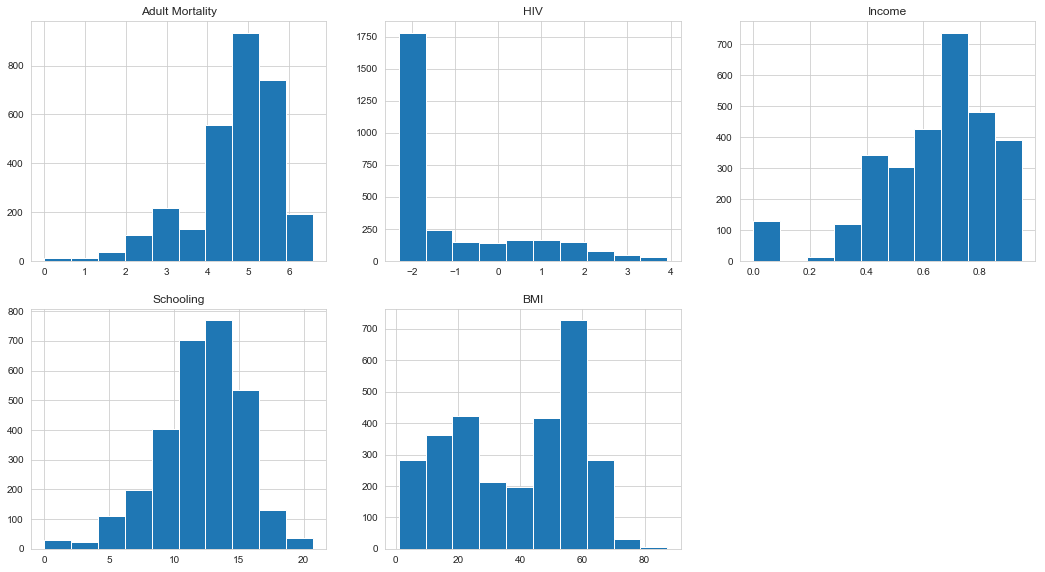

In [58]:
plt.figure(figsize=(18,15))

# histograms of the original data
plt.subplot(3, 3, 1)
plt.hist(lifex["Adult Mortality"])
plt.title("Adult Mortality")

plt.subplot(3, 3, 2)
plt.hist(np.log(lifex["HIV/AIDS"]))
plt.title("HIV")

plt.subplot(3, 3, 3)
plt.hist(lifex["Income composition of resources"])
plt.title("Income")

# histograms of the winsorized data
plt.subplot(3, 3, 4)
plt.hist(lifex["Schooling"])
plt.title("Schooling")

plt.subplot(3, 3, 5)
plt.hist(lifex["BMI"])
plt.title("BMI")

plt.show()

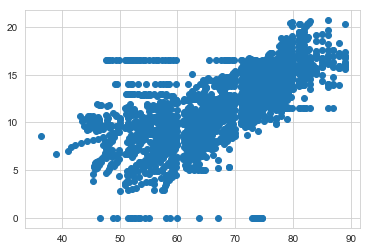

In [59]:
plt.scatter(lifex['Life expectancy'] ,lifex['Schooling'] )

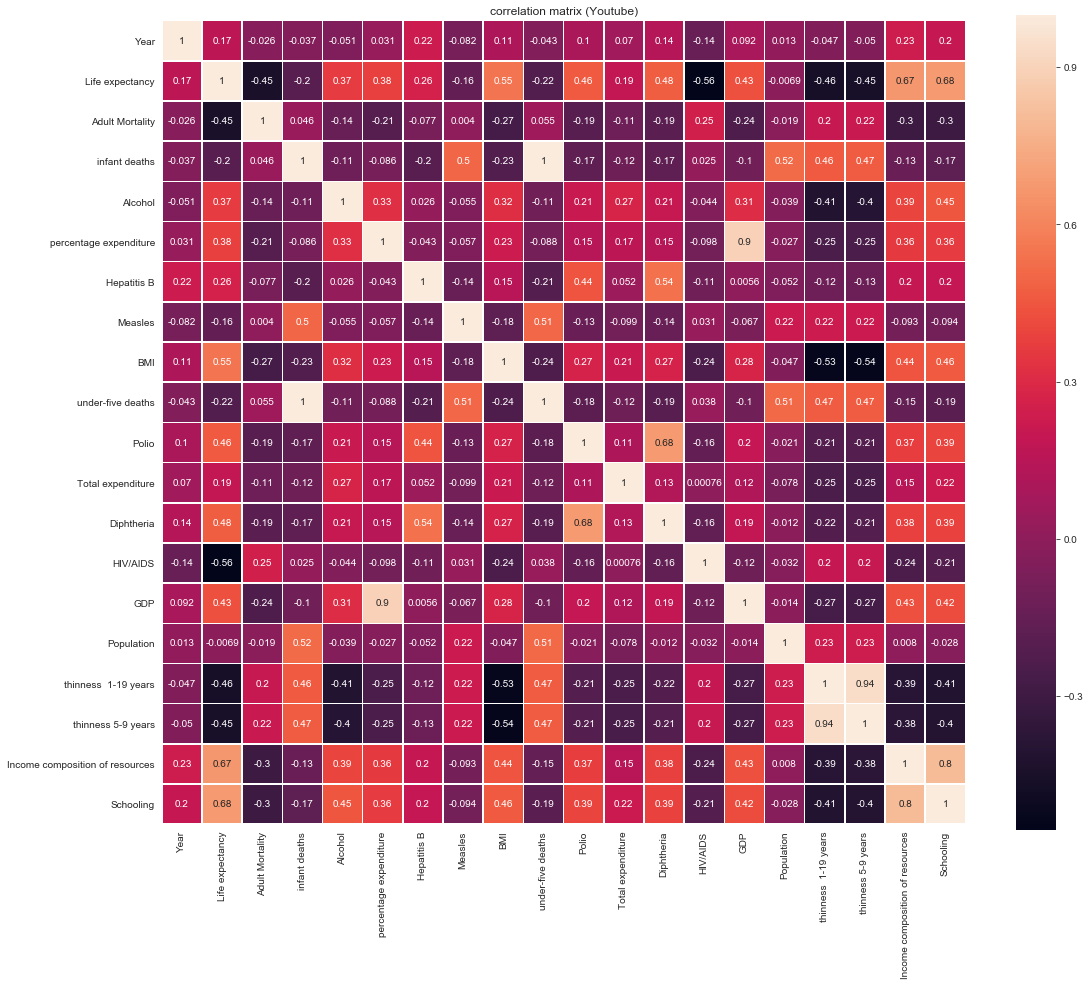

In [60]:
# make the correlation matrices.
corr_mat_lifex = lifex.corr()


# heatmaps are a great way to get 
# a quick visual read on a big correlation matrix.

plt.figure(figsize=(18,15))

plt.plot(1,1)
# draw the heatmap using seaborn.
sns.heatmap(corr_mat_lifex, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (Youtube)")

plt.show()

# try to match the correlation numbers 
# to the scatterplots above to get a 
# sense of what each magnitude of 
# correlation can look like.


In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

## Feature Engineering

In [87]:
lifex_pca = lifex.drop(columns=['Country','Status'])
lifex_pca.dropna(inplace=True)
# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
X = StandardScaler().fit_transform(lifex_pca)

# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)

# eigen values and vectors
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

sklearn_pca = PCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X)

P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(Xt)


In [91]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification


pca = PCA(n_components=2)
X_transformed = pca.fit_transform(X)

# We center the data and compute the sample covariance matrix.
X_centered = X - np.mean(X, axis=0)
cov_matrix = np.dot(X_centered.T, X_centered) / n_samples
eigenvalues = pca.explained_variance_
for eigenvalue, eigenvector in zip(eigenvalues, pca.components_):    
    print(np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)))
    print(eigenvalue)
    print('*')

17.437507503754677
5.939205550865186
*
7.778353225877701
2.64930076851459
*


In [92]:
len(sklearn_pca.components_)

2

Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.


ValueError: array length 20 does not match index length 2938